In [1]:
seed = 1

from nasbench import api

nasbench_path = '../data/nasbench_only108.tfrecord'
nb = api.NASBench(nasbench_path)

import torch
from info_nas.datasets.arch2vec_dataset import get_labeled_unlabeled_datasets

#torch.backends.cudnn.benchmark = True
device = torch.device('cuda')

# device = None otherwise the dataset is save to the cuda as a whole
dataset, _ = get_labeled_unlabeled_datasets(nb, device=device, seed=seed,
                                            train_pretrained=None,
                                            valid_pretrained=None,
                                            train_labeled_path='../data/train_long.pt',
                                            valid_labeled_path='../data/valid_long.pt')

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 35 seconds
Loading nasbench dataset (arch2vec) from ../data/nb_dataset.json
Processing labeled nets for the training set...
Loading labeled dataset from ../data/train_long.pt.
Processing labeled nets for the validation set...
Loading labeled dataset from ../data/valid_long.pt.


In [6]:
from info_nas.datasets.io.semi_dataset import labeled_network_dataset
from scripts.train_vae import get_transforms

transforms = get_transforms('../data/scales/scale-train-include_bias.pickle',
                            True, None, True)

labeled = labeled_network_dataset(dataset['train'], transforms=transforms)

In [3]:
for b in labeled:
    print(b[3].shape)
    break

torch.Size([513])


In [7]:
import numpy as np

np_outs = [b[3].detach().numpy() for b in labeled]

In [8]:
labeled_mean = np.mean(np_outs, axis=0)
labeled_mean = torch.Tensor(labeled_mean)
labeled_mean.shape

torch.Size([513])

In [9]:
import torch
import torch.nn as nn

gen = torch.utils.data.DataLoader(labeled, batch_size=32, shuffle=True, num_workers=4)
ref = labeled_mean.repeat(32, 1)
#ref = torch.full((32, 513), np.mean(np_outs))
loss = nn.MSELoss()

losses = []
for b in gen:
    l = loss(ref, b[3])
    losses.append(l.item())

In [10]:
np.mean(losses)

0.6752368976865945

In [49]:
transforms_val = get_transforms('../data/scales/scale-valid-include_bias.pickle',
                                True, None, True)
labeled_val = labeled_network_dataset(dataset['valid'], transforms=transforms_val)

val_outs = [b[3].detach().numpy() for b in labeled_val]
labeled_mean_val = np.mean(val_outs, axis=0)
labeled_mean_val = torch.Tensor(labeled_mean_val)

In [134]:
gen2 = torch.utils.data.DataLoader(labeled_val, batch_size=32, shuffle=False, num_workers=4)

ref = labeled_mean_val.repeat(32, 1)
#ref = labeled_mean.repeat(32, 1)
#ref = torch.full((32, 513), np.mean(val_outs))
loss = nn.MSELoss()

losses = []
for b in gen2:
    if b[3].shape != ref.shape:
        print('Prr')
        continue
    
    l = loss(ref, b[3])
    losses.append(l.item())

np.mean(losses)

Prr


0.642895296123111

In [2]:
check_path = '../data/vae_checkpoints/2021-09-07_18-41-11/model_concat_epoch-6.pt'
trained_checkpoint = torch.load(check_path, map_location=device)

In [5]:
from arch2vec.extensions.get_nasbench101_model import get_arch2vec_model
from info_nas.models.utils import load_extended_vae


model, optimizer = get_arch2vec_model(device=device)
model, _ = load_extended_vae(check_path, [model, 3, 513], device=device)

In [108]:
how_many = 20

orig = []
pred = []

for i, b in enumerate(gen):
    if i >= how_many:
        break
    
    res = model(b[1].to(device), b[0].to(device), b[2].to(device))
    pred.append(res[-1].detach().cpu().numpy())
    orig.append(b[3].numpy())
        
orig = np.vstack(orig)
pred = np.vstack(pred)

<IPython.core.display.Javascript object>


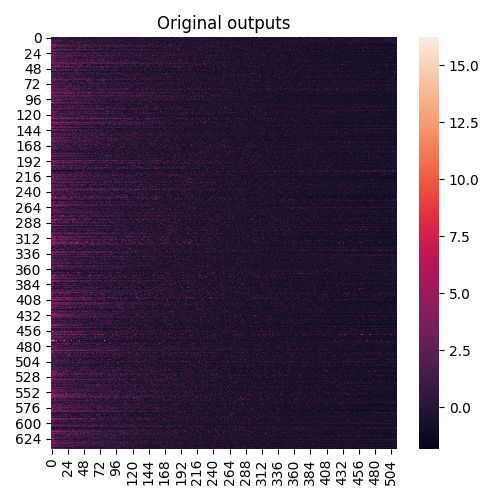

<IPython.core.display.Javascript object>


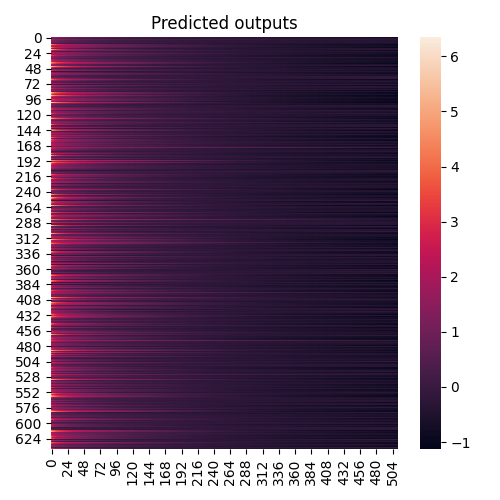

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

plt.close()
plt.figure(figsize=(5,5))
plt.title("Original outputs")
sns.heatmap(orig)
plt.tight_layout()
plt.show()


plt.figure(figsize=(5,5))
plt.title("Predicted outputs")
sns.heatmap(pred)
plt.tight_layout()
plt.show()

In [144]:
how_many = 20

orig = []
pred = []

for i, b in enumerate(gen2):
    if i >= how_many:
        break
    
    res = model(b[1].to(device), b[0].to(device), b[2].to(device))
    pred.append(res[-1].detach().cpu().numpy())
    orig.append(b[3].numpy())
        
orig = np.vstack(orig)
pred = np.vstack(pred)

<IPython.core.display.Javascript object>


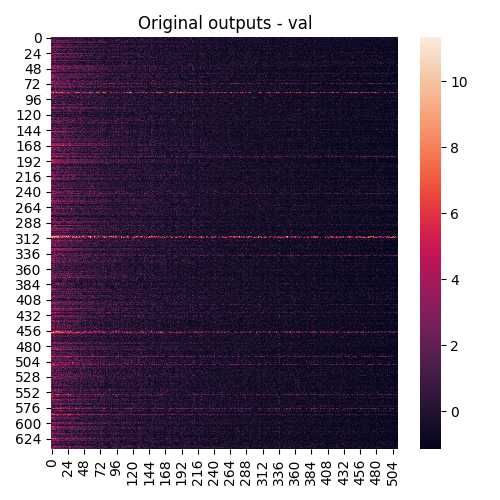

<IPython.core.display.Javascript object>


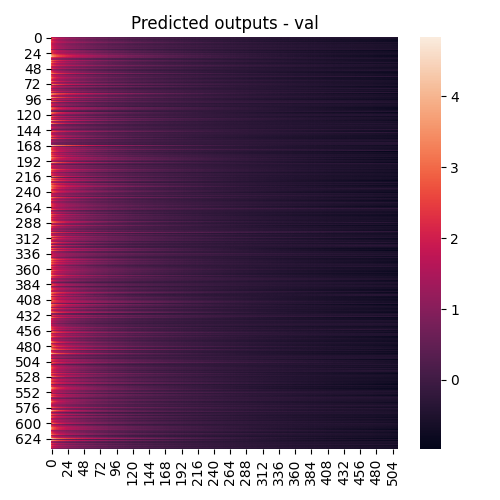

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

plt.close()
plt.figure(figsize=(5,5))
plt.title("Original outputs - val")
sns.heatmap(orig)
plt.tight_layout()
plt.show()


plt.figure(figsize=(5,5))
plt.title("Predicted outputs - val")
sns.heatmap(pred)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


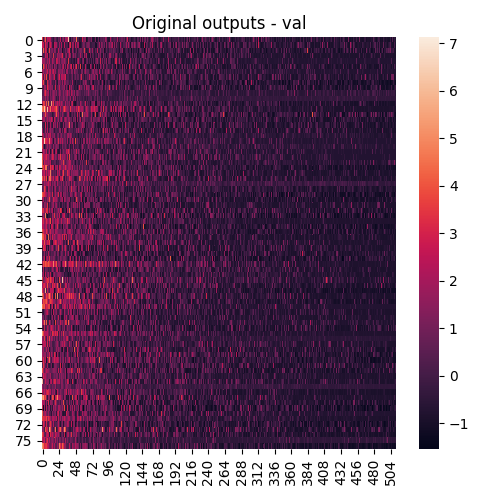

<IPython.core.display.Javascript object>


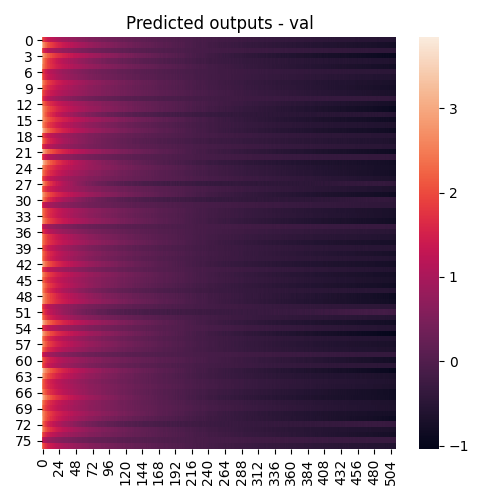

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

plt.close()
plt.figure(figsize=(5,5))
plt.title("Original outputs - val")
sns.heatmap(orig)
plt.tight_layout()
plt.show()


plt.figure(figsize=(5,5))
plt.title("Predicted outputs - val")
sns.heatmap(pred)
plt.tight_layout()
plt.show()

In [128]:
orig = []
pred = []

first = None

print(len(gen))
for i, b in enumerate(gen):
    if i % 100 == 0:
        print(i)
    
    if first is None:
        first = b[2][0]
    
    res = model(b[1].to(device), b[0].to(device), b[2].to(device))
    
    pbatch = res[-1].detach().cpu().numpy()
    obatch = b[3].numpy()
    
    for ins, o, p in zip(b[2], obatch, pbatch):
        if (ins == first).all():
            pred.append(p)
            orig.append(o)

19000
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18

<IPython.core.display.Javascript object>


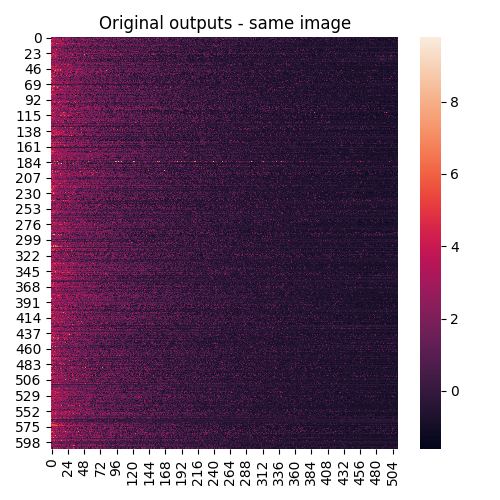

<IPython.core.display.Javascript object>


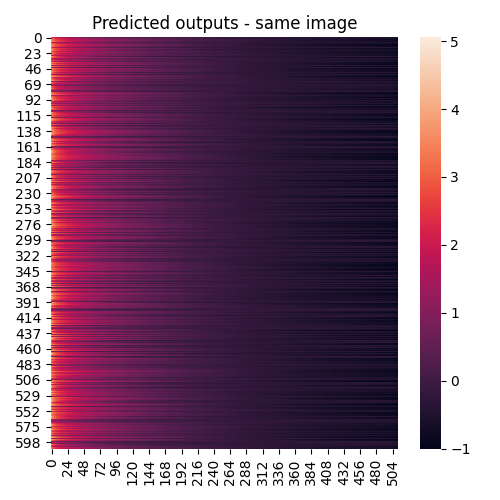

In [132]:
orig_im = np.array(orig)
pred_im = np.array(pred)


plt.figure(figsize=(5,5))
plt.title("Original outputs - same image")
sns.heatmap(orig_im)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.title("Predicted outputs - same image")
sns.heatmap(pred_im)
plt.tight_layout()
plt.show()

In [11]:
orig = []
pred = []

first = None

print(len(gen))
for i, b in enumerate(gen):
    if i % 100 == 0:
        print(i)
    
    if first is None:
        first = b[0][0], b[1][0]
    
    res = model(b[1].to(device), b[0].to(device), b[2].to(device))
    
    pbatch = res[-1].detach().cpu().numpy()
    obatch = b[3].numpy()
    
    for adj, ops, o, p in zip(b[0], b[1], obatch, pbatch):
        if (adj == first[0]).all() and (ops == first[1]).all():
            pred.append(p)
            orig.append(o)

19000
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18

<IPython.core.display.Javascript object>


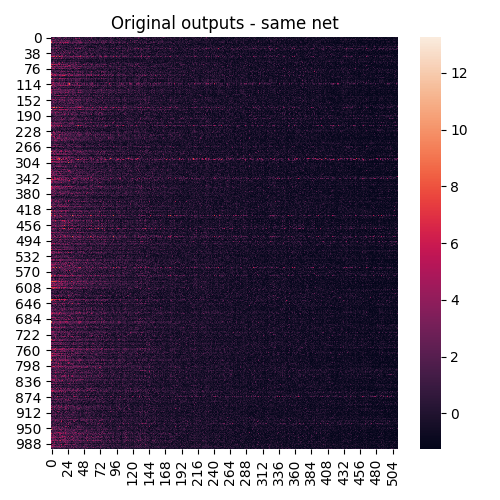

<IPython.core.display.Javascript object>


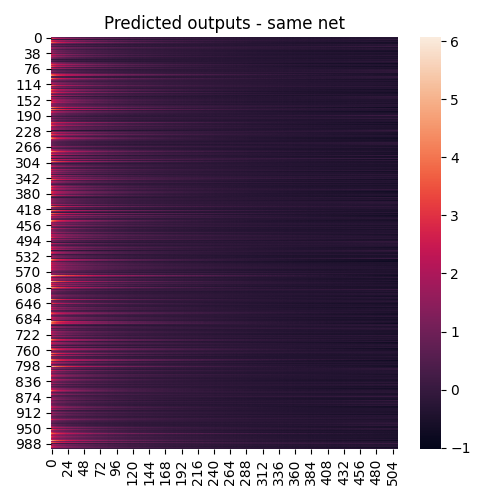

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

orig_im = np.array(orig)
pred_im = np.array(pred)


plt.figure(figsize=(5,5))
plt.title("Original outputs - same net")
sns.heatmap(orig_im)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.title("Predicted outputs - same net")
sns.heatmap(pred_im)
plt.tight_layout()
plt.show()

In [14]:
how_many = 20

orig = []
pred = []

for i, b in enumerate(gen):
    if i >= how_many:
        break
    
    res = model(b[1].to(device), b[0].to(device), b[2].to(device))
    pred.append(res[-1].detach().cpu().numpy())
    orig.append(b[3].numpy())
        
orig = np.vstack(orig)
pred = np.vstack(pred)

<IPython.core.display.Javascript object>


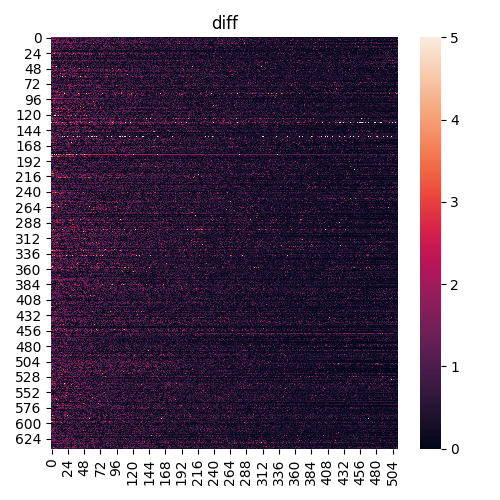

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

diff = np.abs(orig - pred)

plt.figure(figsize=(5,5))
plt.title("diff")
sns.heatmap(diff, vmax=5)
plt.tight_layout()
plt.show()

In [31]:
pred.min()

-1.1526783